### Import

In [4]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 14.4 MB/s 


In [ ]:
!pip install livelossplot --quiet

In [2]:
#%load_ext tensorboard

In [25]:
#@title
#
from pathlib import Path
import re
import random
import math
import functools
import shutil
import os
import itertools
import datetime

import IPython
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import PIL.Image
import pickle

#
import numpy as np
import pandas as pd
from skimage import exposure
import tensorflow as tf
import tensorflow.keras.applications as tfkapp
#from tensorboard.plugins.hparams import api as hp

import livelossplot

#google
from google.colab import drive

import keras_tuner

### Manage directories

#### mount drive to colab machine


In [5]:
# mount google drive to /content/drive/MyDrive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### define useful constants

In [6]:
DEV = True

#common paths
C_PATH      = Path('/content/') 
IMG_PATH    = C_PATH  / 'Images/'
P6_PATH     = C_PATH  / 'drive/MyDrive/FormationML/P6/data/'
LOG_PATH    = P6_PATH / 'logs/'
#TUNER_PATH  = P6_PATH  / 'tuner/'
TUNER_PATH  = C_PATH  / 'tuner/'

# flag to force sampling
FORCE_TEST_SAMPLING = False
FORCE_DEV_SAMPLING = False

# random seed
SEED = 123

TRAIN_SIZE = 0.75
VAL_SIZE   = 0.15
TEST_SIZE  = 0.10
BATCH_SIZE  = 32
IMG_SIZE    = (224,224)

# Images for dev path (limited number of class)
I_PATH2 = C_PATH / 'Images-dev/'
# Images for dev path (limited number of class)
T_PATH2 = C_PATH / 'Images-tst-dev/'
# num classes
NUM_CLASSES2 = 3

# Images path
I_PATH = C_PATH / 'Images/'
# Images for testing path
T_PATH = C_PATH / 'Images-test/'
# num classes
NUM_CLASSES = 120

# random seed
def set_seed(seed):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

set_seed(SEED)

# directories handling
rm_dir  = lambda dir: shutil.rmtree(dir) if (dir is not None and dir.exists()) else None

# run tf functions eagerly
tf.config.run_functions_eagerly(True)

rm_dir(Path('/content/sample_data'))


#### untar images.tar (uploaded to drive) to /content/Images/

In [7]:
! tar -xvf  /content/drive/MyDrive/FormationML/P6/data/images.tar
! ls /content/Images/ |  wc -l
! find /content/Images/ -type f | wc -l

Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n02109047-Great_Dane/n02109047_8090.jpg
Images/n02109047-Great_Dane/n02109047_875.jpg
Images/n021

In [8]:
#! ls /content/Images/ |  wc -l

In [9]:
#! find /content/Images/ -type f | wc -l

#### class ImgDir

- Les images sont répertoriées ainsi:
<pre>
racine/Images/annotation-breed/annotation-id.jpg
</pre>
⚠ id pas unique

In [10]:
class ImgDir:
  def __init__(self,root,seed):
    self.root             = root
    self.test_dir         = self.root / '../Images-test/'
    self.dev_dir          = self.root / '../Images-dev/'
    self.dev_test_dir     = self.root / '../Images-tst-dev/'

    self.all_images       = lambda : list(self.root.glob('*/*.jpg'))
    self.images           = lambda dir: dir.glob('*.jpg')
    self.rm               = lambda dir: shutil.rmtree(dir) if (dir is not None and dir.exists()) else None
    self.image_count      = lambda dir: len(list(self.images(dir)))  
    self.breed_annotation = {t[2]:t[1] for t in [ re.split('(n[0-9]*)-(.*)',dir.name) for dir in self.root.iterdir()]}
    self.breed_dir        = lambda breed: self.root / f"{self.breed_annotation[breed]}-{breed}"\
                               if self.breed_annotation.get(breed) is not None\
                               else None
    self.breeds           = list(self.breed_annotation.keys())
    self.random_from_list = lambda l: l[random.randrange(0,len(l))]
    # generate seed for each breed
    N = 1000
    self.seeds = {breed: random.randrange(N) for breed in self.breeds}
    self.seeds['dev'] = random.randrange(N)

  def clean(self,dir):
    self.rm(dir)
    os.mkdir(dir)

  def path(self,id='random',breed=None):
    if id == 'random' and breed is None:
      return self.random_from_list(list(self.all_images()))
    elif breed is not None:
      dir = self.breed_dir(breed)
      if dir is None:
        print(f'unknown breed: {breed}')
        return
      else:
        if id == 'random':
          return self.random_from_list(list(self.images(dir)))
        else:
            l= list(self.root.glob(f'*{breed}/*_{id}.jpg'))
            if len(l) > 0:
              return l[0]
            else:
              print(f"can't find img with id {id} for {breed}")
    else:
      l= list(self.root.glob(f'*/*_{id}.jpg'))
      if len(l) > 0:
        return l
      else:
        print(f"can't find img with id {id}")
  
  def breed_samples(self,breed,p):
    prop = lambda p,n: math.floor(p*n) if math.floor(p*n) > 0 else math.ceil(p*n)
    # images for the given breed
    imgs = list(self.images(self.breed_dir(breed)))
    n = len(imgs)
    #set seed
    random.seed(self.seeds[breed])
    #select images randomly
    r = range(n)
    k = prop(n,p)
    return [imgs[i] for i in random.sample(r,k)]
  
  def dst_dir(self,root_dst,breed):
    bdir = self.breed_dir(breed).parts[-1]
    return root_dst / bdir
  
  #def test_samples(self,root_dst,p):
  #  for breed in self.breeds:
  #    # dest dir for the given breed
  #    ddir = self.dst_dir(root_dst,breed)
  #    os.mkdir(ddir)
  #    for f in self.breed_samples(breed,p):
  #      shutil.move(src=str(f),dst=str(ddir))

  def test_samples(self,p,force=False,root_dst=None):
    if self.test_dir.exists() and force == False:
      print("NO test sampling executed")
    else:
      #self.test_dir = root_dst if root_dst is not None else self.test_dir
      self.clean(self.test_dir)
      for breed in self.breeds:
        # dest dir for the given breed
        ddir = self.dst_dir(self.test_dir,breed)
        os.mkdir(ddir)
        for f in self.breed_samples(breed,p):
          shutil.move(src=str(f),dst=str(ddir))
      print("Test sampling executed")

  def dev_samples(self,num_class,force=False):
    if self.dev_dir.exists() and self.dev_test_dir.exists() and force == False:
      print("NO dev sampling executed")
    else:    
      random.seed(self.seeds['dev'])
      selected_breeds  = [self.random_from_list(self.breeds) for i in range(num_class)]
      selected_dirs    = [ f"{self.breed_annotation[breed]}-{breed}" for breed in selected_breeds]
      # create directories
      self.clean(self.dev_dir)
      self.clean(self.dev_test_dir)
      for dir in selected_dirs:
        # copy dev
        #os.mkdir(self.dev_dir / dir)
        shutil.copytree(self.root/dir,self.dev_dir/dir)
        # copy test
        #os.mkdir(self.dev_test_dir / dir,)
        shutil.copytree(self.test_dir/dir, self.dev_test_dir/dir)
      print(f"Dev sampling executed - selected breeds: {selected_breeds}")

  def data_expand(self,img_features,aug_img,p=0.1):
    
    if p < 1.0:
      nb_target = int((1.0+p)*img_features.groupby(['breed']).size().mean())
      print(f"nb images target {nb_target} (increase average number per {p})")
    else:
      nb_target = 'all'
      print(f"double all classes")

    return [aug_img.augmented_class(dir,nb_target) for dir in [self.breed_dir(breed) for breed in self.breeds] ]
    
img_dir = ImgDir(IMG_PATH,SEED)

#### Display images characteristics

,height,width
count,20580.000000,20580.000000
mean,385.861224,442.531876
std,124.863446,142.792308
min,100.000000,97.000000
25%,333.000000,361.000000
50%,375.000000,500.000000
75%,453.000000,500.000000
max,2562.000000,3264.000000


mode
RGB     20579
RGBA        1
dtype: int64

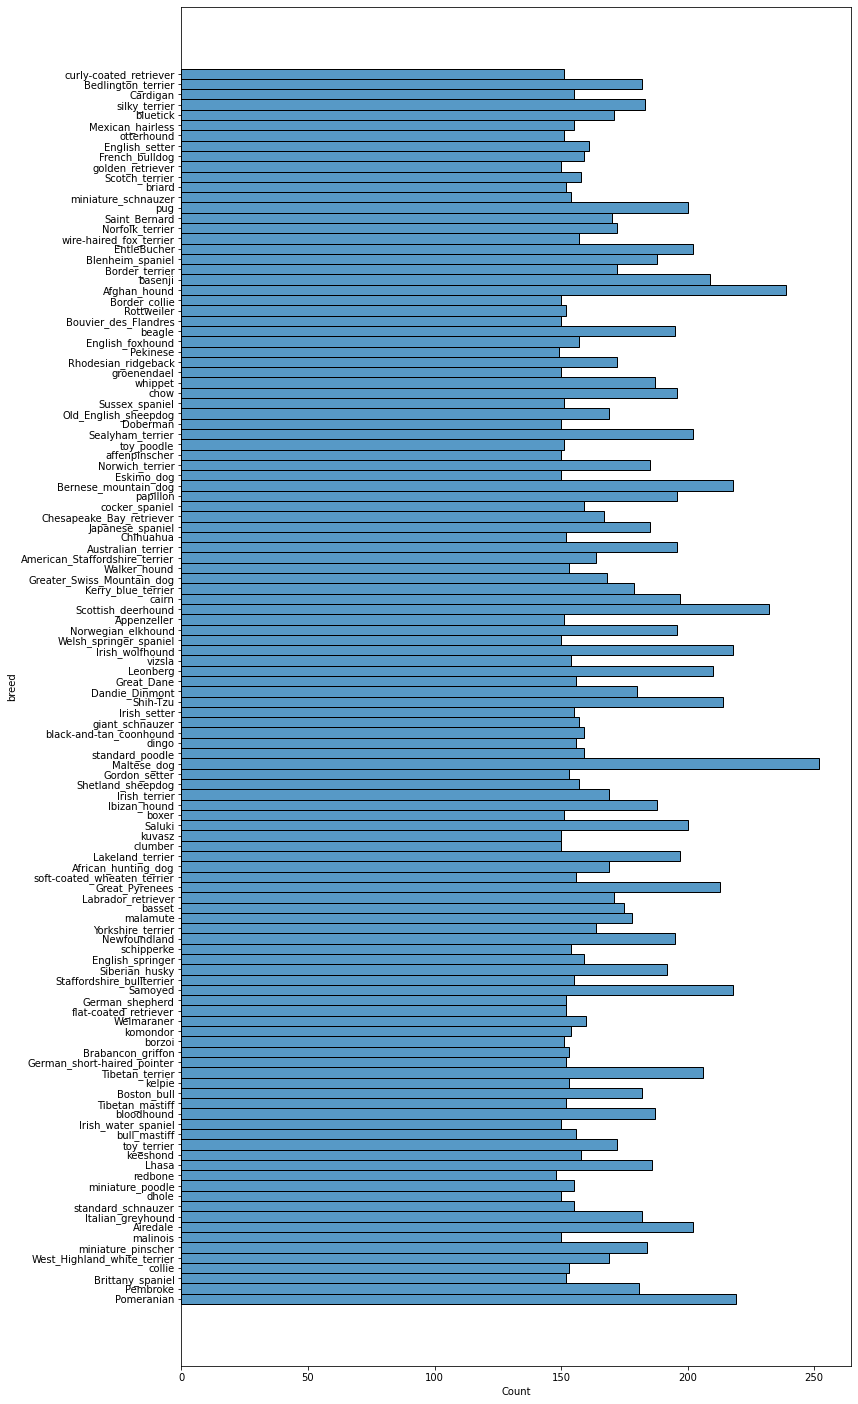

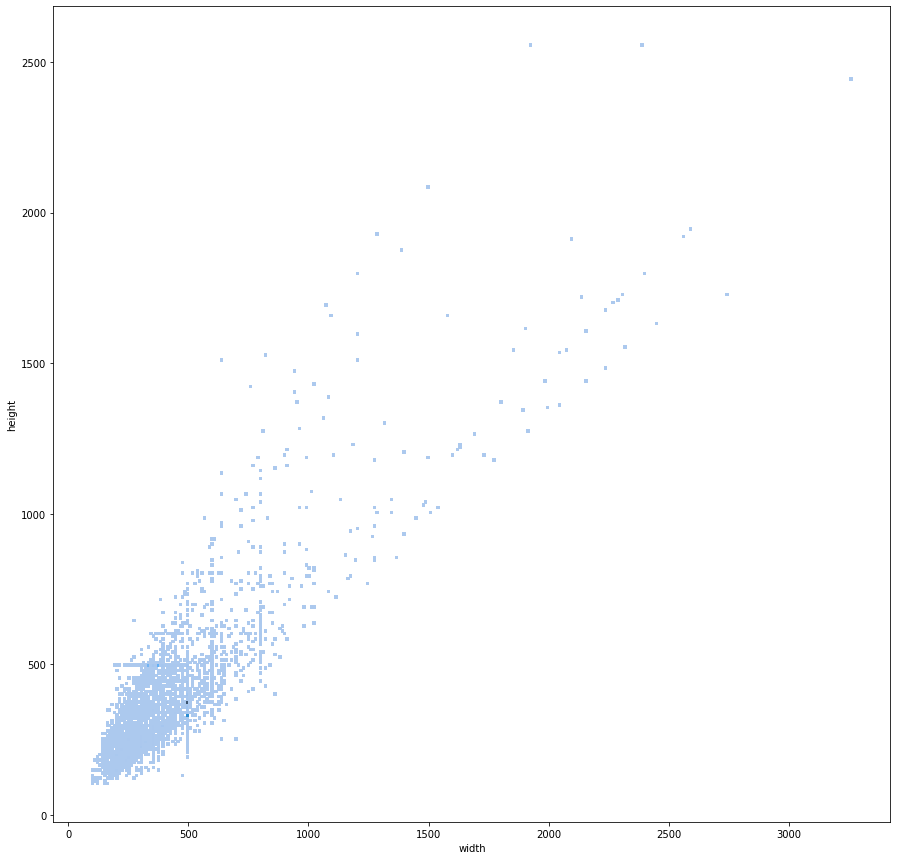

In [11]:
img_open = lambda p: PIL.Image.open(str(p),'r')
img_info = lambda img,info: {'mode':img.mode,'height':img.height,'width':img.width}[info]

def img_features(img_dir):
  infos = ['mode','height','width']
  data = { **{'breed':[], 'ids':[]}, 
            **{info:[] for info in infos}
          }
  for (breed,dir) in [(breed,img_dir.breed_dir(breed)) for breed in img_dir.breeds]:
    data['breed'].extend([breed]*img_dir.image_count(dir))
    data['ids'].extend([img.name for img in img_dir.images(dir)])
    
    for img in map(lambda p:img_open(p),img_dir.images(dir) ):
      for info in infos:
        data[info].extend([img_info(img,info)])

  return pd.DataFrame(data=data)

img_df = img_features(img_dir)

display(img_df.describe())
display(img_df.groupby(['mode']).size())

ax = lambda s : (plt.subplots(figsize=s))[1]
_ = sns.histplot(data=img_df,y='breed',ax=ax((12,25)))

ax = lambda s : (plt.subplots(figsize=s))[1]
_ = sns.histplot(data=img_df,x='width',y='height',ax=ax((15,15)))

Affichage des différents modes et tailles

*   modes: presque que du RGB
    - RGB (3x8-bit pixels, true color)
    - RGBA (4x8-bit pixels, true color with transparency mask)
*   tailles: non homogènes



Remove image RGBA

In [12]:
for p in img_dir.all_images():
  if img_info(img_open(p),'mode') == 'RGBA':
    print(f"remove image: {p}")
    p.unlink()

remove image: /content/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


#### Create test and dev samples

In [13]:
img_dir.test_samples(TEST_SIZE,FORCE_TEST_SAMPLING)
! find /content/Images/ -type f | wc -l
! find /content/Images-test/ -type f | wc -l

img_dir.dev_samples(NUM_CLASSES2,FORCE_DEV_SAMPLING)
! find /content/Images-dev/ -type f | wc -l
! find /content/Images-tst-dev/ -type f | wc -l

Test sampling executed
18570
2009
Dev sampling executed - selected breeds: ['Ibizan_hound', 'Great_Dane', 'malinois']
446
48


### Datasets

#### function dataset_from_dir

In [14]:
# resizing is part of the dataset definition. So will be automatically used for 
# fitting. will need to add that to preprocessing layer when using the model
def dataset_from_dir(dir,
                     subsets = ["training","validation"],
                     validation_split=VAL_SIZE,
                     batch_size=BATCH_SIZE,
                     image_size=IMG_SIZE,
                     ):
  return list(map(
    lambda subset: tf.keras.utils.image_dataset_from_directory(
                                                    directory=dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    class_names=None,
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    image_size=image_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                    validation_split=validation_split,
                                                    subset=subset,
                                                    interpolation='bilinear',
                                                    follow_links=False,
                                                    crop_to_aspect_ratio=False
                                                  ),
                    subsets
    ))


#### preprocess layers

In [15]:
def select_dim(i,s):
  tmp = np.zeros(shape=s)
  tmp[:,:,i] = 1.0
  return tmp

def equalize(img):
    #print(f"shape: {img.shape} {type(img)}")
    s = img.shape
    for i in range(3):
      img[:,:,i] = exposure.equalize_hist(img,mask=select_dim(i,s))[:,:,i]
    return img

@tf.function (input_signature=[tf.TensorSpec(shape=(None,None,3), dtype=tf.float32)])
def tf_equalize(img):
  with tf.init_scope():
    return equalize(img.numpy())

class Equalize(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
      super(Equalize, self).__init__(**kwargs)

    def call(self, inputs,train=False):
        return tf_equalize(inputs)
    
    def compute_output_signature(self,input_signature):
      return input_signature
        

In [16]:
#rescale
rescale_layer = tf.keras.layers.Rescaling(scale=(1./255))
rescale = lambda ds: ds.map( lambda x, y: (rescale_layer(x), y))

#equalize layer
equalize_layer = Equalize()
eq = lambda ds: ds.map( lambda x, y: (equalize_layer(x), y))

# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.2,fill_mode='nearest'),
  tf.keras.layers.RandomZoom(height_factor=0.2,width_factor=0.2,fill_mode='nearest'),
  tf.keras.layers.RandomTranslation( height_factor=0.2,width_factor=0.2,fill_mode='nearest')
])
aug_ds = lambda ds: ds.map( lambda x, y: ( data_augmentation(x), y) )

# apply_preprocess
def apply_preprocess(preprocesses,dss):
  tmp = dss
  for preprocess in preprocesses:
    tmp = list(map(preprocess,tmp))
  return tmp

#performance
def configure_for_performance(ds):
  #ds = ds.cache() (OOM)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

perf = lambda dss: list(map(configure_for_performance,dss))


#### get_data_sets

In [17]:
def get_data_sets(train_actions,tst_val_actions,pref=True,dev=False,ret='tuple'):

  do_perf = lambda dss: perf(dss) if pref is True else dss
                             
  if  dev is True:
    (train_ds,val_ds) = dataset_from_dir(I_PATH2)
    (test_ds,) = dataset_from_dir(T_PATH2,subsets=[None],validation_split=None)
  else:
    (train_ds,val_ds) = dataset_from_dir(I_PATH)
    (test_ds,) = dataset_from_dir(T_PATH,subsets=[None],validation_split=None)

  if train_actions is not None:
   [train_ds] = apply_preprocess(train_actions,do_perf([train_ds]))

  if tst_val_actions is not None:
    [val_ds,test_ds] = apply_preprocess(tst_val_actions,do_perf([val_ds,test_ds]))

  if ret == 'dict':
    return {'train_ds':train_ds,'val_ds':val_ds,'test_ds':test_ds}
  else:
    return (train_ds,val_ds,test_ds)


### Display preprocessing and data augmentation

#### Common functions

In [ ]:
#tf.config.run_functions_eagerly(True)
#(train_ds,val_ds) = dataset_from_dir(I_PATH2,batch_size=None)
#equalize_layer = Equalize()
#def equalize_func(x,y):
#  return (tf.py_function(func=equalize_layer,inp=x,Tout=tf.float32),y)
#  
#tf.data.experimental.enable_debug_mode()
#eq = lambda ds: ds.map(lambda x,y: (tf.py_function(func=equalize,inp=x,Tout=tf.float32),y))
#_ = apply_preprocess([eq],[train_ds])

In [ ]:
def display_ax_img(ax,img,t):
  ax.axis('off')
  ax.imshow(img)
  ax.set_title(t, fontsize=6)

def display_cmp_img(imgs,t,dpi=150):
  fs   = (5,5) 
  fig,axes = plt.subplots(nrows=1,ncols=2,figsize=fs,dpi=dpi)
  _ = list(map(lambda t: display_ax_img(*t),zip(axes,imgs,['original',f'after {t}']) ))

def cmp_img(trans,dpi=150):
  img_paths = trans[:2]
  t    = trans[2]
  imgs = list(map(tf.keras.preprocessing.image.load_img,img_paths))
  display_cmp_img(imgs,t,dpi=dpi)

def apply_cmp_img(img_path,preprocessor,t="preprocessing"):
  img       = tf.keras.preprocessing.image.load_img(img_path)
  np_img    = tf.keras.preprocessing.image.img_to_array(img)
  pp_np_img = preprocessor(np_img,training=True)
  display_cmp_img([img,tf.keras.preprocessing.image.array_to_img(pp_np_img)],t)

#### Display preprocess

In [ ]:
#input = tf.keras.Input(name="input",shape=IMG_SIZE + (3,))
preprocess = tf.keras.models.Sequential(
    name = "preprocess",
    layers = [   
        tf.keras.layers.Resizing(*IMG_SIZE,crop_to_aspect_ratio=False),
        tf.keras.layers.Rescaling(scale=(1./255)),
        Equalize()  
    ]
)
#(input)
for i in range(5):
  apply_cmp_img(img_dir.path(),preprocess)

NameError: ignored

#### display data augmentation

In [ ]:
flip     =  tf.keras.layers.RandomFlip("horizontal_and_vertical")
rot      =  tf.keras.layers.RandomRotation(factor=0.2,fill_mode='nearest')
zoom     =  tf.keras.layers.RandomZoom(height_factor=0.2,width_factor=0.2,fill_mode='nearest')
trans    =  tf.keras.layers.RandomTranslation( height_factor=0.1,width_factor=0.1,fill_mode='nearest')
contrast = tf.keras.layers.RandomContrast(factor=0.2)

aug_fs = [(flip,"flip"),(rot,"rotation"),(zoom,"zoom"),(trans,"trans"),(contrast,"contrast")] 

for t in zip([img_dir.path() for i in range(len(aug_fs))],aug_fs):
  apply_cmp_img(t[0],t[1][0],t[1][1])

### Train models

#### Common definitions

##### hyper-model and hyper-parameters

In [18]:
# hyperparameters accesssors according to mode
def rate_i(hp,mode,i,v):
  rate_name = f"rate_{str(i)}"
  if mode == "tune":
    #return  hp.Choice(name = rate_name, values = v)
    return  hp.Float(name = rate_name, min_value=v[0], max_value=v[1], sampling="linear")
  else:
    return  hp.get(name = rate_name)

def learning_rate(hp,mode):
  if mode == "tune":
    return hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  else:
    return hp.get("lr")

def activation(hp,mode,i):
  if mode == "tune":
    return hp.Choice(f"act_{i}", values = ['relu','tanh'])
  else:
    return hp.get(f"act_{i}")

# hyper model
def hyper_model_gen(hp,model_name,mode,num_classes,models):

  model = (models.get(model_name))(hp,mode,num_classes)

  if model is None:
    raise Exception(f"Unknown model {model_name}")

  return model


##### Définition des layers

In [19]:
# convolution_relu 
convolution_relu = functools.partial(tf.keras.layers.Conv2D, kernel_size=3, activation='relu', padding="same")
# convolution 
convolution = functools.partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same")
# max_pooling
max_pooling = functools.partial(tf.keras.layers.MaxPooling2D, pool_size=(2,2), strides=(2,2))
# fully_connected
fully_connected = functools.partial(tf.keras.layers.Dense,units=4096, activation='relu')
# fully_connected
hp_fully_connected = functools.partial(tf.keras.layers.Dense,units=4096)
# soft_max
soft_max = functools.partial(tf.keras.layers.Dense, activation = 'softmax')

##### Check points and directory related functions

In [20]:
my_time_stamp = lambda : f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
log_dir       = lambda name: str( LOG_PATH / f'{name}_{my_time_stamp()}')
model_file    = lambda name: f"{name}.h5" if DEV is False else f"{name}_{my_time_stamp()}_dev.h5"
model_path    = lambda name: str(P6_PATH / f'models/{model_file(name)}')

#https://keras.io/api/callbacks/model_checkpoint/
#checkpoint
checkpoint = functools.partial(tf.keras.callbacks.ModelCheckpoint,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
mk_checkpoint_cb = lambda path: checkpoint(filepath=path)

#tensorboard (OOM)
# mk_tensorboard_cb = lambda name: tf.keras.callbacks.TensorBoard(log_dir=log_dir(name), histogram_freq=1)

##### fit_and_evaluate

In [21]:
def fit_and_evaluate(model,model_name,train_ds,val_ds,test_ds,patience=5,min_delta=0.001,max_epochs=100):
  
  #callbacks
  m_path_str        = model_path(model_name)
  checkpoint_cb     = mk_checkpoint_cb(m_path_str)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=patience,min_delta=min_delta,restore_best_weights=True,verbose=1)
  #tensorboard_cb    = mk_tensorboard_cb(model_name) 
  callbacks         = [early_stopping_cb,checkpoint_cb,livelossplot.PlotLossesKeras()]
  
  #fit model
  history = model.fit(
                  x=train_ds,
                  epochs=max_epochs,
                  steps_per_epoch=None,
                  validation_data=val_ds,
                  callbacks=callbacks)
  
  # load best model
  best_model = None
  if(Path(m_path_str).exists()):
    print(f"\n===== Load best model from: {m_path_str} =====\n")
    best_model= tf.keras.models.load_model(m_path_str,custom_objects={'Equalize':Equalize})
  else:
    best_model = model

  #evalute
  evaluation = best_model.evaluate(test_ds)
  print("\n===== EVALUATE =====\n")
  print(f"test loss, test acc: {evaluation}")
  print("\n====================\n")

  #
  return (history,evaluation)

##### tune_fit_and_evaluate

In [22]:
def tune_fit_and_evaluate(hyper_model,model_name,train_ds,val_ds,test_ds,
                          tune_patience=3,tune_min_delta=10,tune_max_epochs=3,
                          fit_patience=5,fit_min_delta=0.001,fit_max_epochs=100):
  
  #tuner
  tuner = keras_tuner.Hyperband(
      hypermodel=functools.partial(hyper_model,model_name=model_name,mode="tune"),
      objective = keras_tuner.Objective("accuracy", direction="max"),
      max_epochs=tune_max_epochs,
      directory= str(TUNER_PATH),
      project_name = model_name
  )

  #callbacks
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=tune_patience,min_delta=tune_min_delta,restore_best_weights=True,verbose=1)
  callbacks         = [early_stopping_cb]

  # hyperparameters tuning                     
  tuner.search(**{'x':train_ds,'validation_data':val_ds,'callbacks':callbacks,'epochs':tune_max_epochs})

  # model with best hyper parameters
  best_hp = tuner.get_best_hyperparameters()[0]
  #print(f"Best hyper parameters: {best_hp}")
  model = functools.partial(hyper_model,model_name=model_name,mode="fit")(hp=best_hp)

  #fit and evaluate model with best hyper-parameters
  return fit_and_evaluate(model=model,model_name=model_name,
                          train_ds=train_ds,val_ds=val_ds,test_ds=test_ds,
                          patience=fit_patience,min_delta=fit_min_delta,max_epochs=fit_max_epochs
                          )


#### Models to be trained  (VGG16)

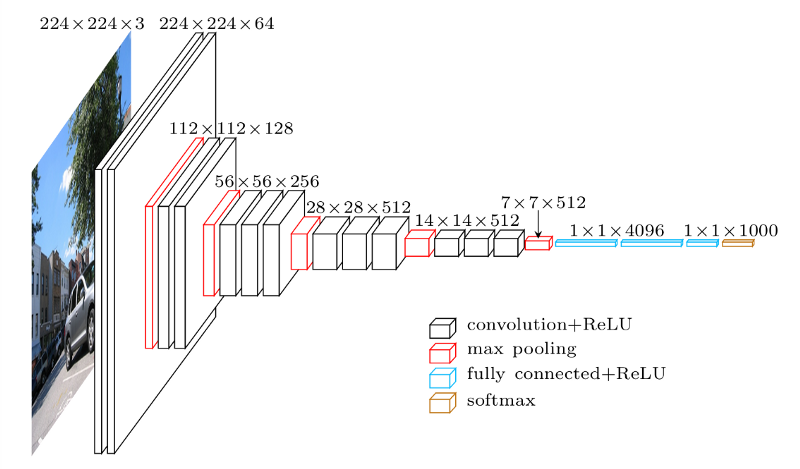

##### Modèle my_VGG16_0

In [23]:
# hyper-model my_VGG16_0
def my_VGG16_0(hp,mode,num_classes):
  model = tf.keras.models.Sequential(
    name = "my_VGG16_0",
    layers = [
        tf.keras.Input(name="input",shape=IMG_SIZE + (3,)),
        Equalize(dynamic=True),                                 
        convolution_relu(filters=64),
        convolution_relu(filters=64),
        max_pooling(),
        convolution_relu(filters=128),
        convolution_relu(filters=128),
        max_pooling(),
        convolution_relu(filters=256),
        convolution_relu(filters=256),
        convolution_relu(filters=256),
        max_pooling(),
        convolution_relu(filters=512),
        convolution_relu(filters=512),
        convolution_relu(filters=512),
        max_pooling(),
        convolution_relu(filters=512),
        convolution_relu(filters=512),
        convolution_relu(filters=512),
        max_pooling(),
        tf.keras.layers.Flatten(),
        fully_connected(),
        fully_connected(),
        soft_max(units=num_classes)
  ])

  model.compile(loss="categorical_crossentropy",
            metrics=["accuracy"], 
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate(hp,mode))
            )

  return model


##### Modèle my_VGG16_1

In [ ]:
# hyper-model my_VGG16_1
def my_VGG16_1(hp,mode,num_classes):
  model = tf.keras.models.Sequential(
    name= "my_VGG16_1",
    layers = [
      tf.keras.Input(name="input",shape=IMG_SIZE + (3,)),
      Equalize(dynamic=True), 
      convolution(filters=64,activation=activation(hp,mode,0)),
      convolution(filters=64,activation=activation(hp,mode,1)),
      max_pooling(),
      convolution(filters=128,activation=activation(hp,mode,2)),
      convolution(filters=128,activation=activation(hp,mode,3)),
      max_pooling(),
      convolution(filters=256,activation=activation(hp,mode,4)),
      convolution(filters=256,activation=activation(hp,mode,5)),
      convolution(filters=256,activation=activation(hp,mode,6)),
      max_pooling(),
      convolution(filters=512,activation=activation(hp,mode,7)),
      convolution(filters=512,activation=activation(hp,mode,8)),
      convolution(filters=512,activation=activation(hp,mode,9)),
      max_pooling(),
      convolution(filters=512,activation=activation(hp,mode,10)),
      convolution(filters=512,activation=activation(hp,mode,11)),
      convolution(filters=512,activation=activation(hp,mode,12)),
      max_pooling(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(rate=rate_i(hp,mode,0,[0.5,0.8])),
      hp_fully_connected(activation=activation(hp,mode,13)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=rate_i(hp,mode,1,[0.5,0.8])),
      hp_fully_connected(activation=activation(hp,mode,14)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=rate_i(hp,mode,2,[0.5,0.8])),
      soft_max(units=num_classes)]
    )
  
  model.compile(loss="categorical_crossentropy",
            metrics=["accuracy"], 
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate(hp,mode))
            )  

  return model


##### Train my_VGG16_0

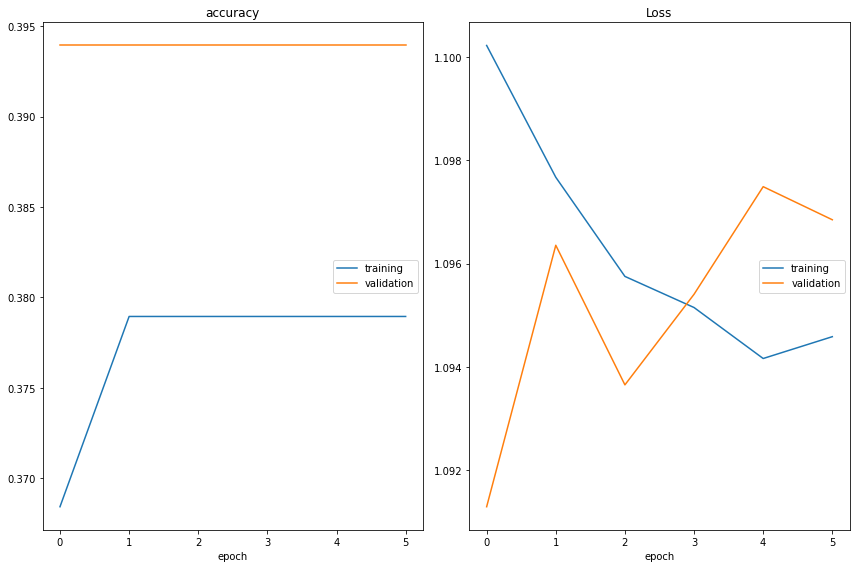

accuracy
	training         	 (min:    0.368, max:    0.379, cur:    0.379)
	validation       	 (min:    0.394, max:    0.394, cur:    0.394)
Loss
	training         	 (min:    1.094, max:    1.100, cur:    1.095)
	validation       	 (min:    1.091, max:    1.097, cur:    1.097)
12/12 [==============================] - 22s 2s/step - loss: 1.0946 - accuracy: 0.3789 - val_loss: 1.0968 - val_accuracy: 0.3939
Epoch 6: early stopping

===== Load best model from: /content/drive/MyDrive/FormationML/P6/data/models/my_VGG16_0_20220713-154032_dev.h5 =====

2/2 [==============================] - 3s 2s/step - loss: 1.0952 - accuracy: 0.3750

===== EVALUATE =====

test loss, test acc: [1.0952141284942627, 0.375]


CPU times: user 5min 10s, sys: 28.4 s, total: 5min 38s
Wall time: 9min 41s


In [26]:
%%time
build_model = functools.partial(hyper_model_gen,models={'my_VGG16_0':my_VGG16_0},num_classes=NUM_CLASSES2)

# pre-trained model has its own preprocess function no need to rescale
(train_ds,val_ds,test_ds) = get_data_sets(train_actions=[rescale,aug_ds],tst_val_actions=[rescale],pref=True,dev=True,ret='tuple')

(hist0,eval0) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_VGG16_0',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)

##### Train my_VGG16_1




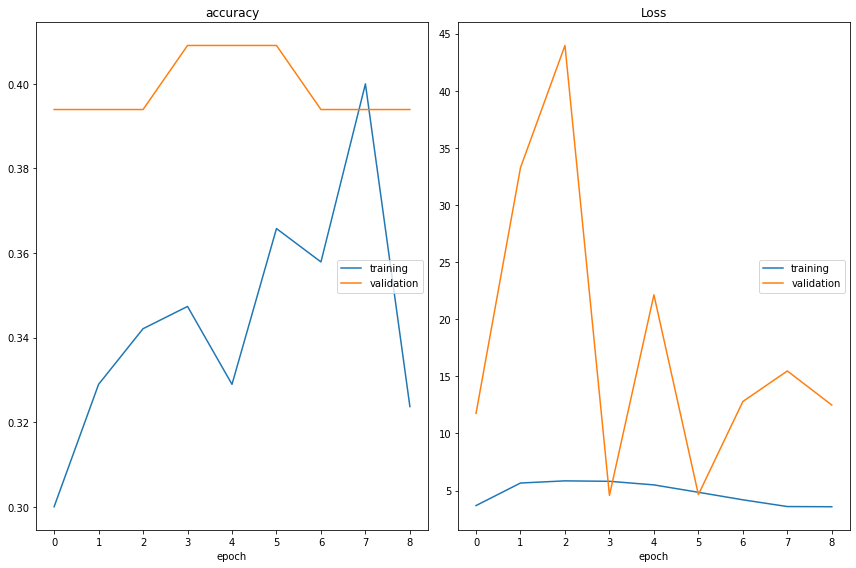

accuracy
	training         	 (min:    0.300, max:    0.400, cur:    0.324)
	validation       	 (min:    0.394, max:    0.409, cur:    0.394)
Loss
	training         	 (min:    3.579, max:    5.844, cur:    3.579)
	validation       	 (min:    4.573, max:   43.961, cur:   12.480)
12/12 [==============================] - 19s 2s/step - loss: 3.5791 - accuracy: 0.3237 - val_loss: 12.4797 - val_accuracy: 0.3939
Epoch 9: early stopping

===== Load best model from: /content/drive/MyDrive/FormationML/P6/data/models/my_VGG16_1_20220713-084630_dev.h5 =====

2/2 [==============================] - 3s 2s/step - loss: 6.6173 - accuracy: 0.3125

===== EVALUATE =====

test loss, test acc: [6.617256164550781, 0.3125]


CPU times: user 2min, sys: 10.7 s, total: 2min 10s
Wall time: 4min 2s


In [ ]:
%%time
build_model = functools.partial(hyper_model_gen,models={'my_VGG16_1':my_VGG16_1},num_classes=NUM_CLASSES2)

# pre-trained model has its own preprocess function no need to rescale
(train_ds,val_ds,test_ds) = get_data_sets(train_actions=[rescale,aug_ds],tst_val_actions=[rescale],pref=True,dev=True,ret='tuple')

(hist1,eval1) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_VGG16_1',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)

#### Transfert learning

In [35]:
def compose_layers(in_,out_):
   return tf.keras.Model(inputs=in_.input,outputs=out_(in_.output))

def get_pretrained_model(model_gen,preprocess):
  # include_top=false ==> remove dense layer of the model
  base_model = model_gen(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))

  # disable training
  for layer in base_model.layers:
      layer.trainable = False

  # add preprocess layer
  i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
  x = tf.cast(i, tf.float32)

  x = preprocess(x)

  x = base_model(x)

  model = tf.keras.Model(inputs=[i], outputs=[x])

  return model


In [33]:
def my_pretrained_vgg1(hp,mode,num_classes):
  #pretrained_vgg16
  pretrained_vgg16 = get_pretrained_model(tfkapp.vgg16.VGG16,tfkapp.vgg16.preprocess_input)

  # preprocess_layers_1
  preprocess_layer = tf.keras.models.Sequential(
    name= "preprocess_layer_1",
  layers = [
      tf.keras.Input(name="input",shape=IMG_SIZE + (3,)),
      Equalize(dynamic=True),  
    ]
  )

  # dense_layers_1
  dense_layers_1 = tf.keras.models.Sequential(
    name= "dense_layers_1",
    layers = [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(rate=rate_i(hp,mode,0,[0.8,0.8])),
            hp_fully_connected(activation=activation(hp,mode,0)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=rate_i(hp,mode,1,[0.5,0.75])),
            hp_fully_connected(activation=activation(hp,mode,1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=rate_i(hp,mode,2,[0.5,0.75])),
            soft_max(units=num_classes)
    ]
  )

  # compose
  model = compose_layers(preprocess_layer,pretrained_vgg16)
  model = compose_layers(model,dense_layers_1)

  #compile
  model.compile(loss="categorical_crossentropy",
            metrics=["accuracy"], 
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate(hp,mode))
            #optimizer='rmsprop'
          )

  return model

#my_pretrained_vgg1(None,None,120).summary()

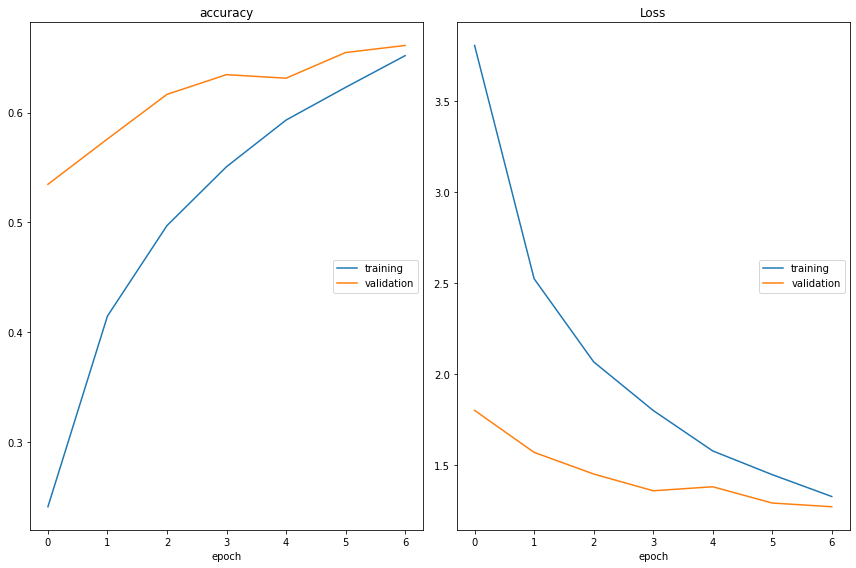

accuracy
	training         	 (min:    0.241, max:    0.652, cur:    0.652)
	validation       	 (min:    0.535, max:    0.661, cur:    0.661)
Loss
	training         	 (min:    1.327, max:    3.806, cur:    1.327)
	validation       	 (min:    1.270, max:    1.800, cur:    1.270)
494/494 [==============================] - 720s 1s/step - loss: 1.3265 - accuracy: 0.6518 - val_loss: 1.2703 - val_accuracy: 0.6610
Epoch 8/100
247/494 [==============>...............] - ETA: 5:18 - loss: 1.2289 - accuracy: 0.6731

In [ ]:
%%time

build_model = functools.partial(hyper_model_gen,models={'my_pretrained_vgg1':my_pretrained_vgg1},num_classes=NUM_CLASSES)

# pre-trained model has its own preprocess function no need to rescale
(train_ds,val_ds,test_ds) = get_data_sets(train_actions=[aug_ds],tst_val_actions=[],pref=True,dev=False,ret='tuple')

(hist2,eval2) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_pretrained_vgg1',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)


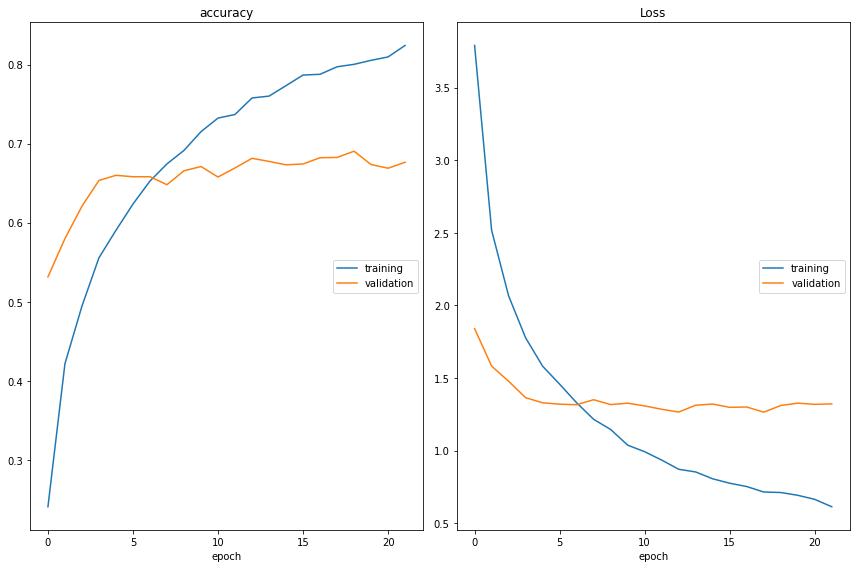

accuracy
	training         	 (min:    0.240, max:    0.824, cur:    0.824)
	validation       	 (min:    0.531, max:    0.690, cur:    0.676)
Loss
	training         	 (min:    0.614, max:    3.790, cur:    0.614)
	validation       	 (min:    1.265, max:    1.841, cur:    1.322)
494/494 [==============================] - 740s 1s/step - loss: 0.6139 - accuracy: 0.8243 - val_loss: 1.3222 - val_accuracy: 0.6765
Epoch 23/100
220/494 [============>.................] - ETA: 6:08 - loss: 0.5876 - accuracy: 0.8303

In [ ]:
%%time

build_model = functools.partial(hyper_model_gen,models={'my_pretrained_vgg1':my_pretrained_vgg1},num_classes=NUM_CLASSES)

# pre-trained model has its own preprocess function no need to rescale
#(train_ds,val_ds,test_ds) = get_data_sets(train_actions=[aug_ds],tst_val_actions=[],pref=True,dev=False,ret='tuple')

(hist2,eval2) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_pretrained_vgg1',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)

Par deux fois, le traitement même sur le modèle pré-entraîné ne s'est pas terminé. On évalue donc le modèle sur la base du dernier modèle enregistré.

In [29]:
model_file = 'my_pretrained_vgg1_20220713-091942_dev.h5'
best_model= tf.keras.models.load_model(f'/content/drive/MyDrive/FormationML/P6/data/models/{model_file}',custom_objects={'Equalize':Equalize})
evaluation = best_model.evaluate(test_ds)
print("\n===== EVALUATE =====\n")
print(f"test loss, test acc: {evaluation}")
print("\n====================\n")


63/63 [==============================] - 58s 906ms/step - loss: 1.3189 - accuracy: 0.6745

===== EVALUATE =====

test loss, test acc: [1.3189197778701782, 0.6744648814201355]




### Prediction tool

In [ ]:
class_names = []
for breed in sorted(os.listdir(IMG_PATH)):
  splitted_breed = breed.split('-')
  if len(splitted_breed) > 2:
    class_names.append('-'.join(splitted_breed[1:]))
  else:
    class_names.append(splitted_breed[1])

pickle.dump(class_names, open(P6_PATH/'models/class_names.save', 'wb'))


In [31]:
class PredictBreed:

  def __init__(self,model_path,classes_path):
      self.model   = tf.keras.models.load_model(model_path,custom_objects={'Equalize':Equalize})
      with open(str(classes_path), "rb") as input_file:
        self.class_names = pickle.load(input_file)
      self.preprocess = tf.keras.models.Sequential(
          name = "preprocess",
          layers = [   
            tf.keras.layers.Resizing(*IMG_SIZE,crop_to_aspect_ratio=False),
            #tf.keras.layers.Rescaling(scale=(1./255))  
          ]
        )  

  def predict(self,img_path):
    img      = tf.keras.preprocessing.image.load_img(img_path)
    np_img   = tf.keras.preprocessing.image.img_to_array(img)
    #simulate batch dim
    input      = np.expand_dims(np_img, axis=0)
    # predict with model 
    preds      = self.model.predict(self.preprocess(input))
    #deduct class name
    pred_label = self.class_names[np.argmax(preds)]

    return pred_label


In [ ]:
pred_model = PredictBreed(str(P6_PATH/'models/my_pretrained_vgg1_20220712-102633_dev.h5'),str(P6_PATH/'models/class_names.save'))
p = img_dir.path()
predicted_breed = pred_model.predict(p)
print(f"{p} Vs {predicted_breed}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/content/Images/n02094258-Norwich_terrier/n02094258_897.jpg Vs Norwich_terrier


In [ ]:
pred_model = PredictBreed(str(P6_PATH/'models/my_pretrained_vgg1_20220712-102633_dev.h5'),str(P6_PATH/'models/class_names.save'))
p = img_dir.path()
predicted_breed = pred_model.predict(p)
print(f"{p} Vs {predicted_breed}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/content/Images/n02086646-Blenheim_spaniel/n02086646_4133.jpg Vs Blenheim_spaniel


In [32]:
pred_model = PredictBreed(str(P6_PATH/'models/my_pretrained_vgg1_20220713-091942_dev.h5'),str(P6_PATH/'models/class_names.save'))
p = img_dir.path()
predicted_breed = pred_model.predict(p)
print(f"{p} Vs {predicted_breed}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/content/Images/n02113978-Mexican_hairless/n02113978_838.jpg Vs Mexican_hairless
